In [1]:
import numpy as np
from matplotlib.pyplot import *

import cv2

IMAGE_DIR = "../data/imgs/lenna.jpg"


animal = imread ("../data/imgs/animal.jpg")

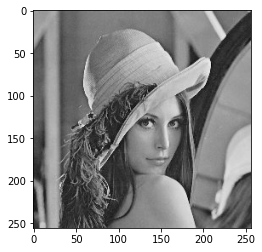

In [2]:
image = imread (IMAGE_DIR)

imshow(image, cmap = "gray")

In [3]:
def gnoise (image, sigma = 12) :
    return image + np.random.normal (0,sigma, np.shape (image))

In [4]:
def neumann_bc (image, border_size = 10) :
    d = border_size
    a, b = np.shape (image)[0], np.shape (image)[1]
        
    A = a + 2 * d
    B = b + 2 * d
    
    I = np.zeros ((A,B))
    
    I [d:(A-d) , d:(B-d)] = image
    
    for i in range (d,A-d) :
        for j in range (0,d) :
            I [i,j] = I [i, 2 * d - j]
            
        for j in range (0,d) :
            I [i,j+B-d] = I [i, B-d-1 - j]
    
    for j in range (0,B) :
        for i in range (0,d) :
            I [i,j] = I [2 * d - i, j]
            
        for i in range (0,d) :
            I [i+B-d,j] = I [B-d-1 - i, j]

    return I

In [5]:
def grad (P) :
    a, b = np.shape (P)[0], np.shape (P)[1]

    Dx = np.zeros ((a,b))
    Dy = np.zeros ((a,b))
    
    for i in range (a-1) :
        for j in range (b-1) :
            if i < a :
                Dx [i,j] = P [i+1,j] - P [i,j]
            elif i == 0 :
                Dx[i,j] = 0

            if j < a :
                Dy [i,j] = P [i,j+1] - P [i,j]
            elif j == 0 :
                Dy [i,j] = 0
            
    return Dx, Dy

def div (P) :
    a, b = np.shape (P)[1], np.shape (P)[2]

    Dx = np.zeros ((a,b))
    Dy = np.zeros ((a,b))

    
    for i in range (a-1) :
        for j in range (b-1) : 
            if 1 < i < a :
                Dx [i,j] = P [0,i,j] - P [0,i-1,j]
            elif i == 1 :
                Dx [i,j] = P [0,i,j]
            elif i == a :
                Dx [i,j] = - P [0,i-1,j]
                
            if 1 < j < a :
                Dy [i,j] = P [1,i,j] - P [1,i,j-1]
            elif j == 1 :
                Dy [i,j] = P [1,i,j]
            elif j == a :
                Dy [i,j] = - P [1,i,j-1]
                
    return Dx + Dy

In [6]:
def PSNR (ud, u) :
    '''Peak Signal to Noise Ratio'''
    return 20 * np.log10 (np.divide (255, np.absolute (norm(ud-u))))
    
def SNR (ud, u) :
    '''Signal to Noise Ratio'''
    return 20 * np.log10 (np.divide (norm(u), norm(ud-u)))

In [22]:
def chambolle1 (g, L = 10, max_iter = 100, tau = 1/8, eps = 1e-15) :
        
    p = np.zeros (np.shape ((g,g)))
    
    for i in range (max_iter) :        

        gd = grad (div(p) - np.divide (g,L))
        
        
        norm_gd = np.sqrt (sum(np.power (gd,2)))
        
        new_p = np.divide (p + np.dot (tau,gd) , 1 + tau*norm_gd)
        
        if np.max (np.abs (new_p - p)) < eps :
            break
        
        p = new_p
    return g - L * div (p)

In [30]:
import time

I = gnoise (image, sigma := 15)

start = time.time()

DI = chambolle1 (g = I)

elapsed = time.time()
elapsed = elapsed - start
print ("Time spent in (function name) is: ", elapsed)

Time spent in (function name) is:  21.50969171524048


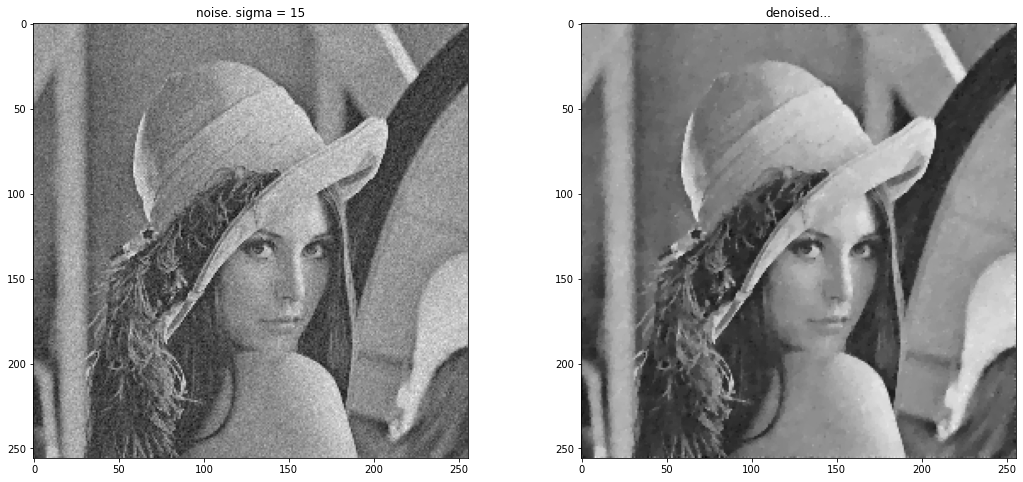

In [26]:
fig = figure(figsize=(18,8))

ax = fig.add_subplot(1, 2, 1)
imshow(I, cmap = 'gray')
ax.set_title(f'noise. sigma = {sigma}')

ax = fig.add_subplot(1, 2, 2)
ax.set_title('denoised...')
imshow(DI, cmap = 'gray')